## Second Order Extended Kalman Filter

Wouter Kouw, last update: 12-02-2023


In [2]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/FRAI2023-nlamb`


In [25]:
using Revise
using Optim
using ForwardDiff
using ProgressMeter
using LinearAlgebra
using Distributions
using Plots
default(label="", grid=false, linewidth=3, markersize=3, margin=10Plots.pt)
include("../util.jl")

e (generic function with 1 method)

## 1D state - 1D sensor

In [4]:
# Grid over state space
N = 500
states = range(0, stop=2π, length=N)

# State covariance
S_t = 1.0

# Observation noise
R = 1e-2

0.01

In [5]:
# Observation function
g(z) = sin(z)

# Derivatives
J(z) = ForwardDiff.derivative(g, z)
H(z) = ForwardDiff.derivative(J, z)

# Curvature
κ(z) = abs(H(z))/(1+ J(z)^2)^(3/2)

κ (generic function with 1 method)

In [6]:
ambET1 = zeros(N)    
for (i,m_t) in enumerate(states)

    # Unscented transform moments
    mE, SE, CE = ET1(m_t, S_t, g, addmatrix=R)

    # Calculate ambiguity
    ambET1[i] = log(max(1e-8,SE-CE'*inv(S_t)*CE))
    
end

In [7]:
ambET2 = zeros(N)    
for (i,m_t) in enumerate(states)

    # Unscented transform moments
    mE, SE, CE = ET2(m_t, S_t, g, addmatrix=R)

    # Calculate ambiguity
    ambET2[i] = log(max(1e-8,SE-CE'*inv(S_t)*CE))
    
end

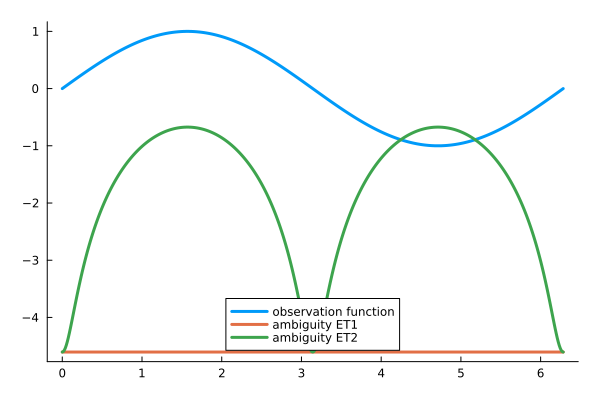

In [8]:
plot(states, g.(states), label="observation function")
plot!(states, ambET1, label="ambiguity ET1", legend=:bottom)
plot!(states, ambET2, label="ambiguity ET2", legend=:bottom)

## 2D states - 1D sensor

In [27]:
m = randn(2)
S = diagm(rand(2))

2×2 Matrix{Float64}:
 0.045655  0.0
 0.0       0.264133

In [28]:
g(x::AbstractVector) = cos(x[1]) + sin(x[2])
Jm = ForwardDiff.gradient(g, m)

2-element Vector{Float64}:
 -0.5005842642099274
 -0.7778902251264387

In [29]:
# Dimensionalities
N = length(g(m))
M = length(m)

Jm = ForwardDiff.gradient(g, m)

2-element Vector{Float64}:
 -0.5005842642099274
 -0.7778902251264387

In [30]:
Hm = ForwardDiff.hessian(g, m)
aux1 = tr(Hm*S)

-0.2055041369059438

In [31]:
aux2 = tr(Hm*S*Hm*S)

0.02911180296426548

In [36]:
μ, Σ, Γ = ET2(m,S,g)

(1.3913359364410016, 0.18582662050055987, [-0.0228541931752549, -0.2054663555101258])

In [37]:
# Grid over state space
T = 100
ring = range(0, stop=2π, length=T)
states = [cos.(ring'); sin.(1/2 .*ring')]

g(x::AbstractVector) = atan(x[1],x[2])

# State covariance
S_t = diagm(ones(2))

# Observation noise
R = nothing

ambET2 = zeros(T)    
for k in 1:T

    # Unscented transform moments
    mE, SE, CE = ET2(states[:,k], S_t, g, addmatrix=R)

    # Calculate ambiguity
    ambET2[k] = logdet(SE-CE'*inv(S_t)*CE)
    
end

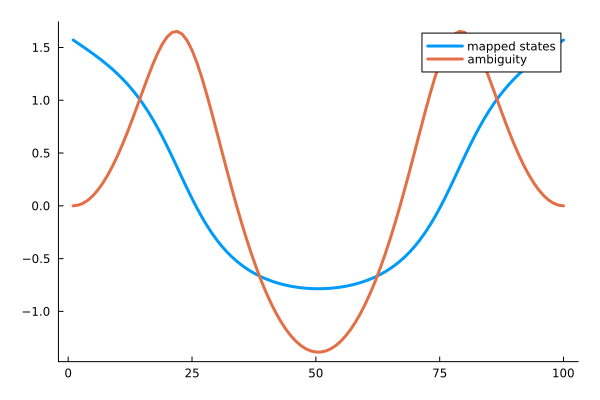

In [39]:
y = cat([g(states[:,i]) for i in 1:T]..., dims=2)
plot(y', label="mapped states")
plot!(ambET2, label="ambiguity")

## 2D states - 3D sensor

In [40]:
m = randn(2)
S = diagm(rand(2))

2×2 Matrix{Float64}:
 0.589721  0.0
 0.0       0.317351

In [41]:
g(x::AbstractVector) = [cos(x[1]), sin(x[2]), tan(x[1]+x[2])]
Jm = ForwardDiff.jacobian(g, m)

3×2 Matrix{Float64}:
 -0.836639  -0.0
  0.0        0.998114
  4.07529    4.07529

In [42]:
# Dimensionalities
N = length(g(m))
M = length(m)

Jm = ForwardDiff.jacobian(g, m)

3×2 Matrix{Float64}:
 -0.836639  -0.0
  0.0        0.998114
  4.07529    4.07529

In [43]:
aux1 = zeros(eltype(m), N)
Hi = zeros(eltype(m), M,M,N)
for i in 1:N
    g_i(x) = g(x)[i]
    Hi[:,:,i] = ForwardDiff.hessian(g_i, m)
    aux1 += e(i,N)*tr(Hi[:,:,i]*S)
end
aux1

3-element Vector{Float64}:
 -0.323022328273568
 -0.01948206345018061
 12.965007129439512

In [44]:
# Auxiliary terms
aux2 = zeros(eltype(m), N,N)
for i in 1:N
    for j in 1:N
        aux2 += e(i,N)*e(j,N)'*tr(Hi[:,:,i]*S*Hi[:,:,j]*S)
    end
end
aux2

3×3 Matrix{Float64}:
  0.104343   0.0           -2.72277
  0.0        0.000379551   -0.0883701
 -2.72277   -0.0883701    168.091

In [45]:
μ, Σ, Γ = ET2(m,S,g)

([0.3862429853827196, 0.05164864664948117, 8.236153021074173], [0.464956263035075 0.0 -3.372064552688049; 0.0 0.3163445762620167 1.2466710190282038; -3.372064552688049 1.2466710190282038 99.11032267751901], [-0.49338410126879606 0.0 2.40328349417185; 0.0 0.3167522351859162 1.2932953980521043])

In [46]:
# Grid over state space
T = 100
ring = range(0, stop=2π, length=T)
states = [cos.(ring'); sin.(1/2 .*ring')]

g(x::AbstractVector) = [sqrt(x[1]^2 + x[2]^2), atan(x[1],x[2])]

# State covariance
S_t = diagm(ones(2))

# Observation noise
R = nothing

ambET2 = zeros(T)    
for k in 1:T

    # Unscented transform moments
    mE, SE, CE = ET2(states[:,k], S_t, g, addmatrix=R)

    # Calculate ambiguity
    ambET2[k] = logdet(SE-CE'*inv(S_t)*CE)
    
end

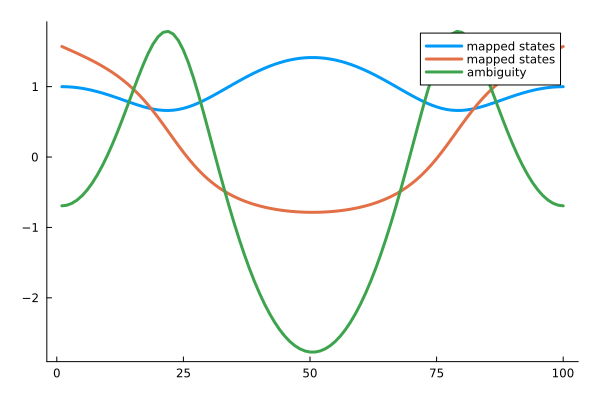

In [48]:
y = cat([g(states[:,i]) for i in 1:T]..., dims=2)
plot(y', label="mapped states")
plot!(ambET2, label="ambiguity")